In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [4]:
# 68,335,729 data points in total
import random
p = 0.0001  # 0.01% of the lines -> 6800 data points
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
"""
df = pd.read_csv(
         'data/all_events.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
"""
df = pd.read_csv('../data/AaltoyliopistoMKorkeakouluaukio_sorted.csv')

## Add some useful columns

In [38]:
# sort based on timestamp
df = df.sort_values('ts')
# the hour and minutes of the timestamp
df['hour_and_minutes'] = df['ts'].apply(lambda x: x[11:16])
# month of timestamp
df['month'] = df['ts'].apply(lambda x: x[5:7])
# the percentage of bikes
df['bikes_percent'] = df['bikes'] / df['total_slots']
df['minutes_from_midnight'] = df['ts'].apply(lambda x: int(x[11:13]) * 60 + int(x[14:16]))
df['hour'] = df['hour_and_minutes'].apply(lambda x: x[:2])
df.head()

,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,bike_added,bike_removed,max_wait_for_new_bike,idle_for,wait_for_bike_taken,hour
0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,False,False,16.0,0.0,1.0,07
1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,False,True,16.0,0.0,10.0,07
2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,False,False,16.0,1.0,9.0,07
3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,False,False,16.0,2.0,8.0,07
4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,False,False,16.0,3.0,7.0,07


## Explore 

In [50]:
df.shape

(142937, 18)

In [6]:
df.describe()

,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight
count,1.429370e+05,1.429370e+05,142937.0,142937.0,142937.000000,142937.000000,142937.000000,142937.000000
mean,6.018431e+01,2.482667e+01,1.0,541.0,7.527197,40.641513,0.185329,730.393320
std,1.421090e-14,1.065818e-14,0.0,0.0,9.217886,0.479558,0.227243,405.433105
min,6.018431e+01,2.482667e+01,1.0,541.0,0.000000,40.000000,0.000000,0.000000
25%,6.018431e+01,2.482667e+01,1.0,541.0,1.000000,40.000000,0.024390,386.000000
50%,6.018431e+01,2.482667e+01,1.0,541.0,4.000000,41.000000,0.097561,731.000000
75%,6.018431e+01,2.482667e+01,1.0,541.0,11.000000,41.000000,0.275000,1080.000000
max,6.018431e+01,2.482667e+01,1.0,541.0,60.000000,41.000000,1.463415,1439.000000


In [7]:
df.head(10)

,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight
0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468
1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469
2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470
3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471
4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472
5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473
6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474
7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475
8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476
9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477


In [8]:
by_hour = df.groupby('hour_and_minutes').mean()[0::60]
by_hour

,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight
hour_and_minutes,,,,,,,,
00:00,60.184312,24.826671,1.0,541.0,2.428571,40.702381,0.059785,0.0
01:00,60.184312,24.826671,1.0,541.0,2.123457,40.641975,0.052401,60.0
02:00,60.184312,24.826671,1.0,541.0,2.455696,40.620253,0.060567,120.0
03:00,60.184312,24.826671,1.0,541.0,2.536082,40.649485,0.062434,180.0
04:00,60.184312,24.826671,1.0,541.0,5.039604,40.633663,0.123901,240.0
05:00,60.184312,24.826671,1.0,541.0,9.959596,40.636364,0.245140,300.0
06:00,60.184312,24.826671,1.0,541.0,12.087379,40.640777,0.297685,360.0
07:00,60.184312,24.826671,1.0,541.0,12.524272,40.640777,0.308371,420.0
08:00,60.184312,24.826671,1.0,541.0,12.278846,40.634615,0.302257,480.0


[Text(0,0,'00:00'),
 Text(0,0,'01:00'),
 Text(0,0,'02:00'),
 Text(0,0,'03:00'),
 Text(0,0,'04:00'),
 Text(0,0,'05:00'),
 Text(0,0,'06:00'),
 Text(0,0,'07:00'),
 Text(0,0,'08:00'),
 Text(0,0,'09:00'),
 Text(0,0,'10:00'),
 Text(0,0,'11:00'),
 Text(0,0,'12:00'),
 Text(0,0,'13:00'),
 Text(0,0,'14:00'),
 Text(0,0,'15:00'),
 Text(0,0,'16:00'),
 Text(0,0,'17:00'),
 Text(0,0,'18:00'),
 Text(0,0,'19:00'),
 Text(0,0,'20:00'),
 Text(0,0,'21:00'),
 Text(0,0,'22:00'),
 Text(0,0,'23:00')]

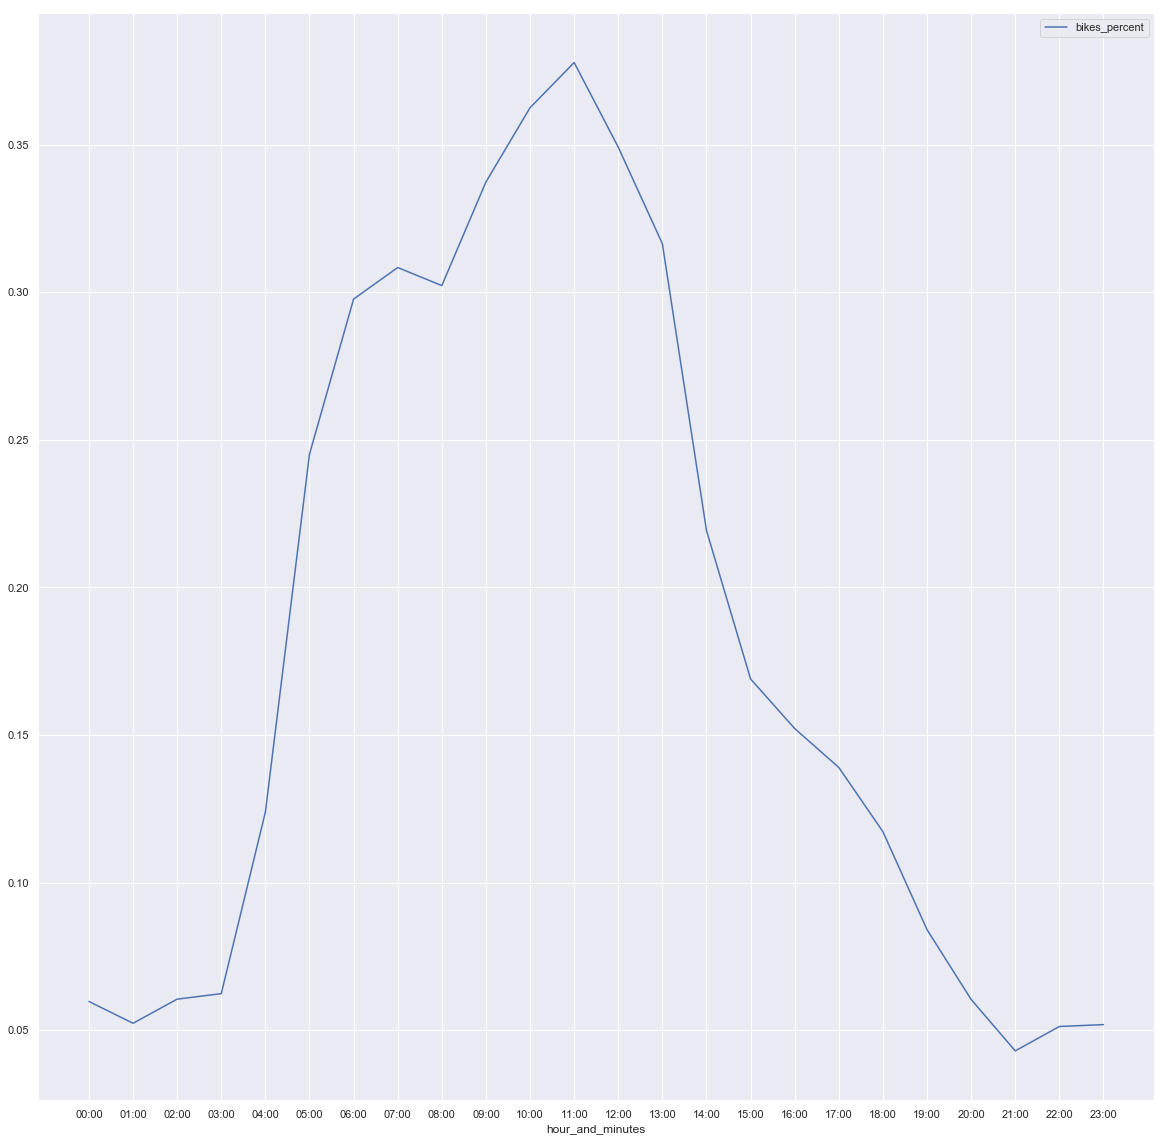

In [9]:
fig, ax = plt.subplots(figsize=(20,20))
by_hour.plot(y='bikes_percent', ax=ax)
ax.set_xticks(range(len(by_hour.index)))
ax.set_xticklabels(by_hour.index)

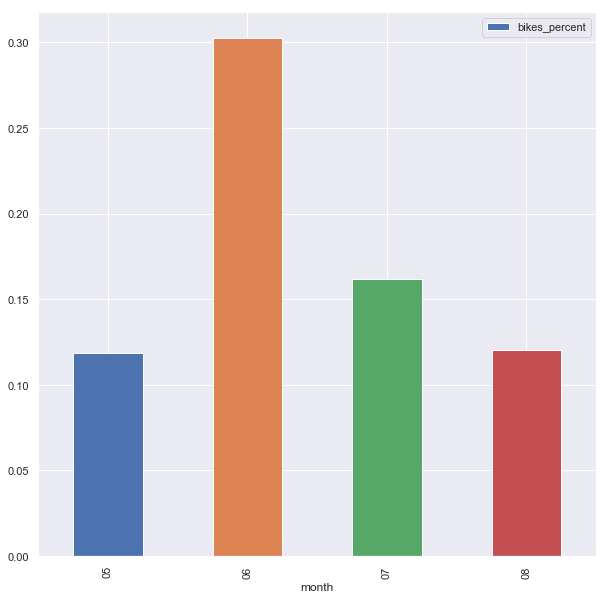

In [10]:
by_month = df.groupby('month').mean()
by_month.plot(y='bikes_percent', kind='bar', figsize=(10, 10))

In [11]:
# this is useful when using data from several stations
by_name = df.groupby('name').mean()
by_name

,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight
name,,,,,,,,
"Aalto-yliopisto (M), Korkeakouluaukio",60.184312,24.826671,1.0,541.0,7.527197,40.641513,0.185329,730.39332


## Prepare for predictions

### Add column which states whether a bike was added at a given moment

In [12]:
df['bike_added'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] < x['bikes'] , axis=1)
df['bike_removed'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] > x['bikes'] , axis=1)
df.head(100)

,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,bike_added,bike_removed
0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,False,False
1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,False,True
2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,False,False
3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,False,False
4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,False,False
5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,False,False
6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,False,False
7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,False,False
8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,False,False
9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,False,False


### Add max waiting time for next bike

In [13]:
# extract difference in minutes to a separate column
# on the moment that a bike was added, the waiting time is the time to next bike
i = 0
first_non_additive_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_added'] == False):
        i += 1
    if (i >= len(df)):
        break
    additive_row = df.iloc[i]
    time = additive_row['minutes_from_midnight']
    difference = abs(time - df.iloc[first_non_additive_index]['minutes_from_midnight'])
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'max_wait_for_new_bike'] = difference 
    first_non_additive_index = i
    i += 1
# if we can't know when the next bike will be added, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,bike_added,bike_removed,max_wait_for_new_bike
0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,False,False,16.0
1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,False,True,16.0
2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,False,False,16.0
3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,False,False,16.0
4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,False,False,16.0
5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,False,False,16.0
6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,False,False,16.0
7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,False,False,16.0
8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,False,False,16.0
9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,False,False,16.0


### Add idle time for each station

In [14]:
i = 0
idle_for = 0
while (i < len(df.head(100))):
    row = df.iloc[i]
    previous_row = df.iloc[(i-1 if i > 0 else 0)]
    if (not row['bikes'] == previous_row['bikes']):
        idle_for = 0
        df.loc[i, 'idle_for'] = idle_for
#         print(row['bikes'], ' != ', previous_row['bikes'])
        i+= 1
        continue
    time_now = row['minutes_from_midnight']
    time_last = previous_row['minutes_from_midnight']
    idle_for += time_now - time_last
    df.loc[i, 'idle_for'] = idle_for
    i += 1
#     print(i)
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,bike_added,bike_removed,max_wait_for_new_bike,idle_for
0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,False,False,16.0,0.0
1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,False,True,16.0,0.0
2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,False,False,16.0,1.0
3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,False,False,16.0,2.0
4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,False,False,16.0,3.0
5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,False,False,16.0,4.0
6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,False,False,16.0,5.0
7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,False,False,16.0,6.0
8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,False,False,16.0,7.0
9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,False,False,16.0,8.0


### Add time for next bike take

Predict how much time for the next bike to be taken: max waiting time is not useful here.

In [15]:
i = 0
first_non_removing_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_removed'] == False):
        i += 1
    if (i >= len(df)):
        break
    removing_row = df.iloc[i]
    time = removing_row['minutes_from_midnight']
    times_until_now = df.loc[first_non_removing_index:i-1, 'minutes_from_midnight']
    difference = abs(time - times_until_now)
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken'] = difference 
    first_non_removing_index = i
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,bike_added,bike_removed,max_wait_for_new_bike,idle_for,wait_for_bike_taken
0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,False,False,16.0,0.0,1.0
1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,False,True,16.0,0.0,10.0
2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,False,False,16.0,1.0,9.0
3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,False,False,16.0,2.0,8.0
4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,False,False,16.0,3.0,7.0
5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,False,False,16.0,4.0,6.0
6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,False,False,16.0,5.0,5.0
7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,False,False,16.0,6.0,4.0
8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,False,False,16.0,7.0,3.0
9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,False,False,16.0,8.0,2.0


## Plot division of max waiting time for new bike

### Sorted by frequency

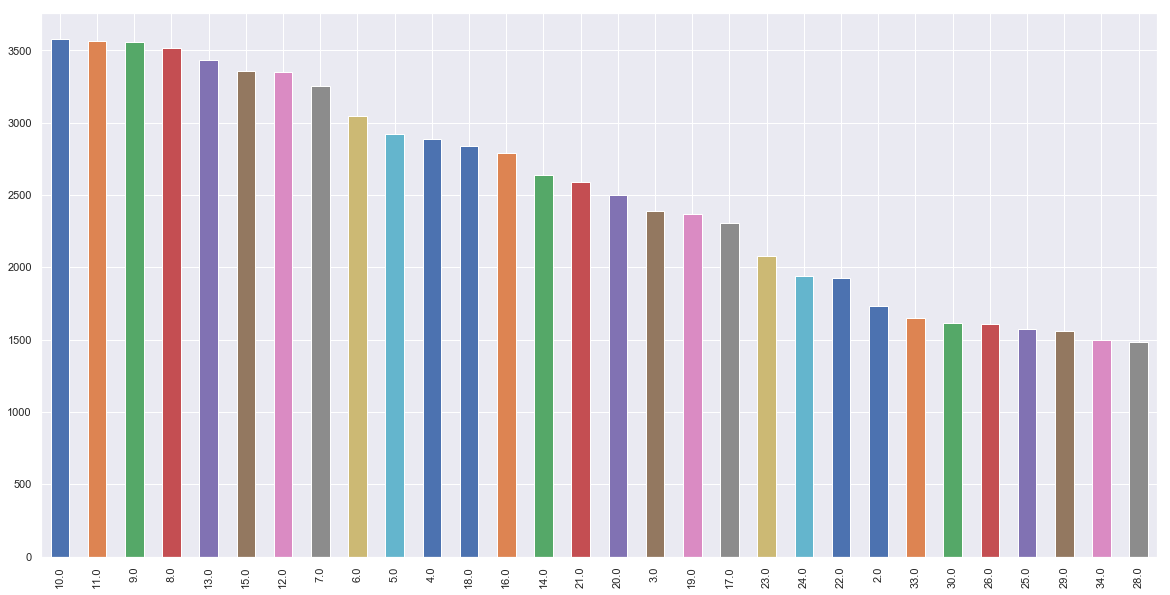

In [16]:
# sort by frequency
by_max_wait = df['max_wait_for_new_bike'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_max_wait.plot(kind='bar', figsize=(20, 10))

### Sorted by waiting time

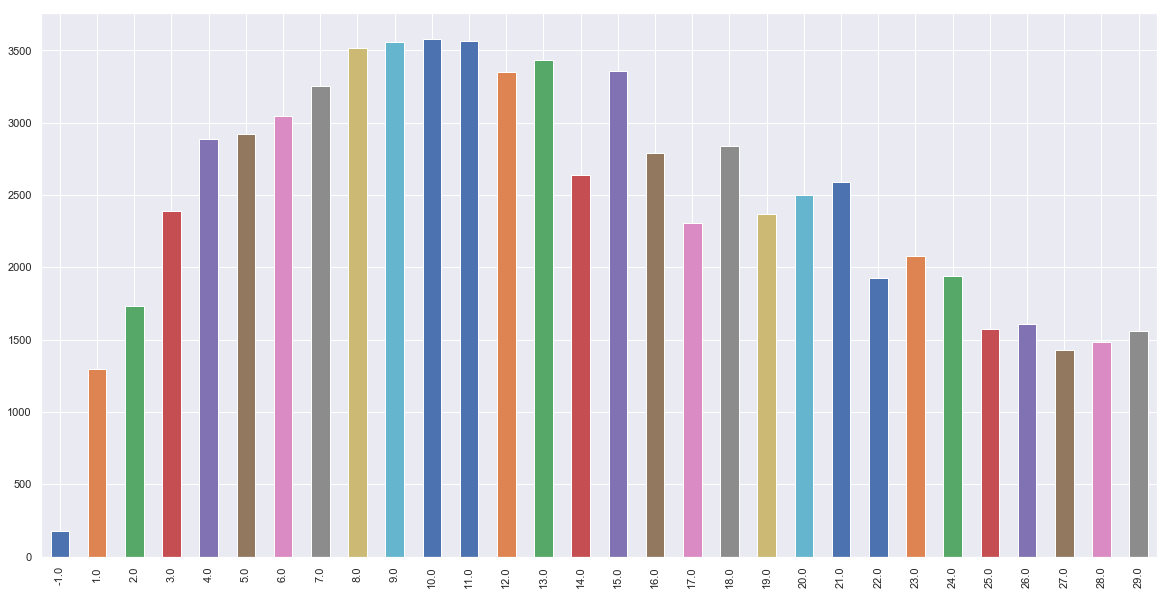

In [17]:
# sort by waiting time
by_max_wait_count = df['max_wait_for_new_bike'].value_counts()
by_max_wait_sorted = by_max_wait_count.sort_index().head(30)
by_max_wait_normalized = by_max_wait_sorted.index
by_max_wait_sorted.plot(kind='bar', figsize=(20, 10))

### Normalized waiting time

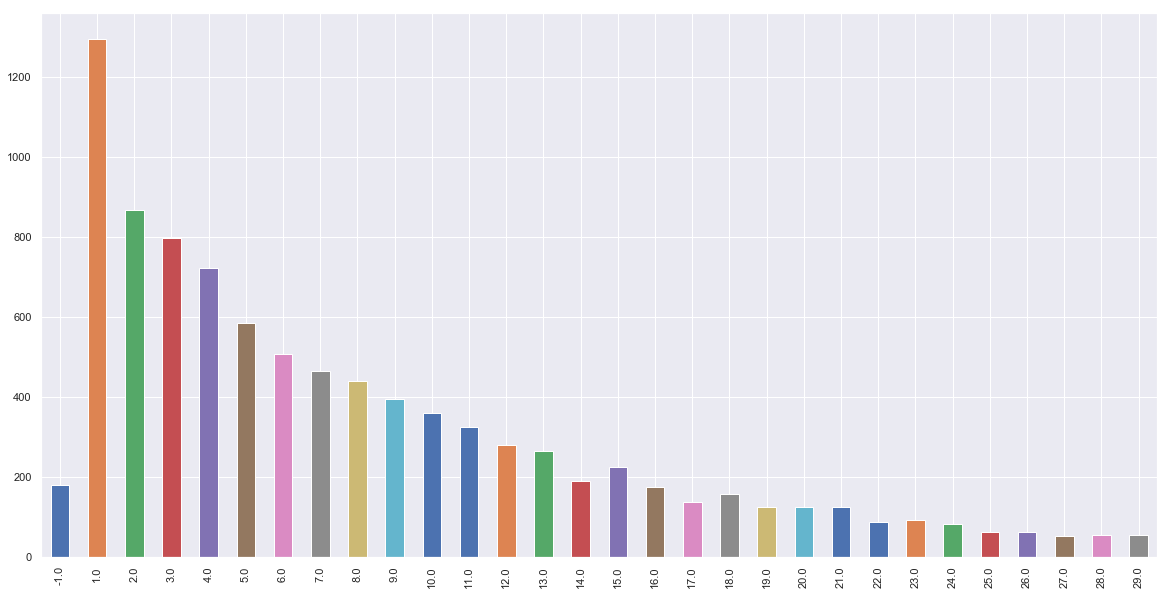

In [18]:
# normalize by dividing by key in order not to emphasize big values
by_max_wait_normalized = abs(by_max_wait_sorted / by_max_wait_sorted.index)
by_max_wait_normalized.plot(kind='bar', figsize=(20, 10))

## Plot division of wait for next taken bike

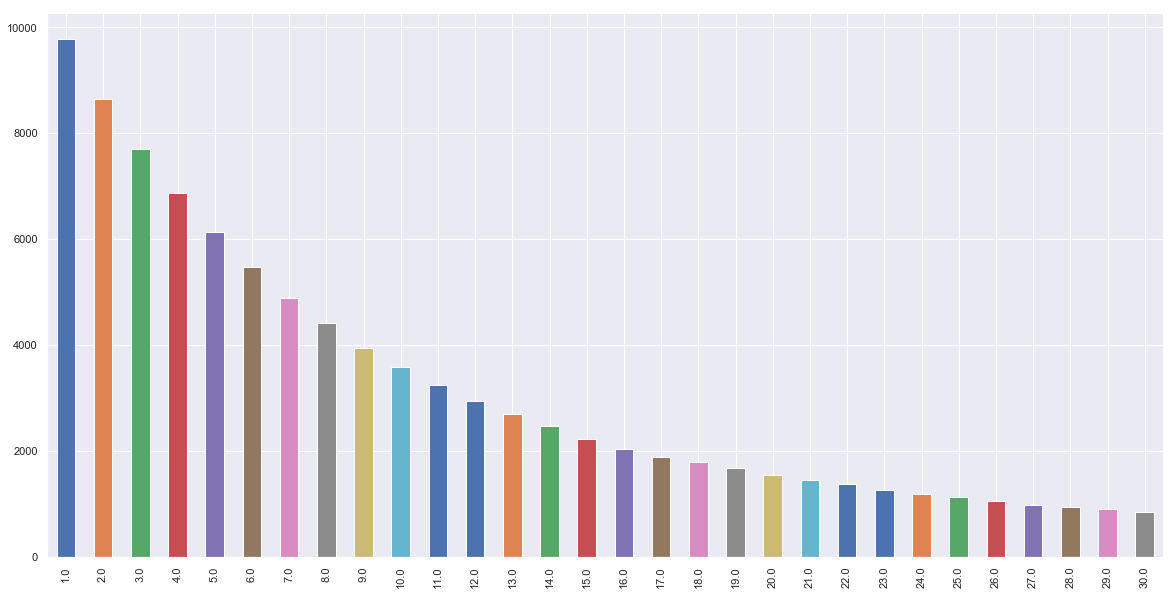

In [19]:
# sort by frequency
by_take_wait = df['wait_for_bike_taken'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_take_wait.plot(kind='bar', figsize=(20, 10))

## Build linear regression models

### Predict when the next bike will be brought

In [44]:
cleaned_df = df.drop(columns=['ts', 'sid', 'hour_and_minutes', 'name', 'bike_added', 'bike_removed', 'lat', 'lon', 'bikes', 'total_slots', 'minutes_from_midnight'])
cleaned_df.head(20)

,operative,month,bikes_percent,max_wait_for_new_bike,idle_for,wait_for_bike_taken,hour
0,1,05,0.125,16.0,0.0,1.0,07
1,1,05,0.100,16.0,0.0,10.0,07
2,1,05,0.100,16.0,1.0,9.0,07
3,1,05,0.100,16.0,2.0,8.0,07
4,1,05,0.100,16.0,3.0,7.0,07
5,1,05,0.100,16.0,4.0,6.0,07
6,1,05,0.100,16.0,5.0,5.0,07
7,1,05,0.100,16.0,6.0,4.0,07
8,1,05,0.100,16.0,7.0,3.0,07
9,1,05,0.100,16.0,8.0,2.0,07


In [40]:
# removes useless columns and the column to predict
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'wait_for_bike_taken'])
print('predicting based on ', ', '.join(x.columns.values))
y = df['max_wait_for_new_bike']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on  operative, month, bikes_percent, minutes_from_midnight, idle_for, hour
score:


0.08977773310896675

### Predict when the next bike will be taken

In [41]:
# removes useless columns and the column to predict
x = cleaned_df.drop(columns=['wait_for_bike_taken', 'max_wait_for_new_bike'])
print('predicting based on ', ', '.join(x.columns.values))
y = df['wait_for_bike_taken']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('accuracy:')
model.score(x_test, y_test)

predicting based on  operative, month, bikes_percent, minutes_from_midnight, idle_for, hour
accuracy:


0.24826326529707632

In [49]:
# removes useless columns and the column to predict
x = cleaned_df.drop(columns=['bikes_percent'])
print('predicting based on ', ', '.join(x.columns.values))
y = df['bikes_percent']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('accuracy:')
model.score(x_test, y_test)

predicting based on  operative, month, max_wait_for_new_bike, idle_for, wait_for_bike_taken, hour
accuracy:


0.11746745269179393